## in this notebook we will learn how to do neural style transfer

youtube [link](https://www.youtube.com/watch?v=imX4kSKDY7s)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import numpy as np

In [2]:
model = models.vgg19(pretrained=True)

In [3]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

we dont need the classifier, so we'll filter that out

In [4]:
model = model.features

In [5]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

let's create a VGG class

In [6]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.chosen_features = ['0','5','10','19','28']
        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        features = []

        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)

        return features

In [7]:
def load_image(image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
image_size = 356
loader = transforms.Compose([transforms.Resize((image_size, image_size)),
                             transforms.ToTensor()])

in this, the only thing that is 'trained' (the only thing that changes), is the the generated image. this is because the rest of the model will be frozen. note that the optimizer takes generated as the parameter

In [9]:
original_image = load_image('girl.jpg')
style_image = load_image('style2.png')
generated = original_image.clone().requires_grad_(True)

In [10]:
original_image.shape, style_image.shape, generated.shape

(torch.Size([1, 3, 356, 356]),
 torch.Size([1, 3, 356, 356]),
 torch.Size([1, 3, 356, 356]))

In [11]:
model = VGG().to(device).eval() #.eval() will freeze the weights

In [12]:
# hyperparameters
total_steps = 2000
learning_rate = 0.001
alpha = 1
beta = 0.01

In [13]:
optimizer = optim.Adam([generated], lr=learning_rate)

### without lr scheduler

In [21]:
for step in range(total_steps):
    generated_features = model(generated)
    original_features = model(original_image)
    style_features = model(style_image)

    style_loss = content_loss = 0

    for gen_feature, orig_feature, style_feature in zip(generated_features, original_features, style_features):
        batch_size, channel, height, width = gen_feature.shape

        content_loss += torch.mean((gen_feature - orig_feature) ** 2)

        # Gram matrix

        G = gen_feature.view(channel, height*width).mm(gen_feature.view(channel, height*width).t())

        A = style_feature.view(channel, height*width).mm(style_feature.view(channel, height*width).t())

        style_loss += torch.mean((G - A) ** 2)

    total_loss = alpha*content_loss + beta*style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 200 == 0:
        print(total_loss)
        save_image(generated, f'generate1_lr_{step}.png')

                               

tensor(175413., device='cuda:0', grad_fn=<AddBackward0>)
tensor(11048.5977, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5833.7324, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3927.3828, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2959.5640, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2393.7466, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2042.1774, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1800.3988, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1615.1174, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1462.9871, device='cuda:0', grad_fn=<AddBackward0>)


### with lr scheduler

In [14]:
from torch.optim import lr_scheduler

#### attempt 1

In [15]:
# decay learning rate by a factor of 0.1 every x epochs. (logic for lr taken from the udemy pytorch course)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [16]:
for step in range(total_steps):
    generated_features = model(generated)
    original_features = model(original_image)
    style_features = model(style_image)

    style_loss = content_loss = 0

    for gen_feature, orig_feature, style_feature in zip(generated_features, original_features, style_features):
        batch_size, channel, height, width = gen_feature.shape

        content_loss += torch.mean((gen_feature - orig_feature) ** 2)

        # Gram matrix

        G = gen_feature.view(channel, height*width).mm(gen_feature.view(channel, height*width).t())

        A = style_feature.view(channel, height*width).mm(style_feature.view(channel, height*width).t())

        style_loss += torch.mean((G - A) ** 2)

    total_loss = alpha*content_loss + beta*style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 200 == 0:
        print(total_loss)
        save_image(generated, f'generate1_lr_{step}.png')
        exp_lr_scheduler.step()
                              

tensor(175413., device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 1.0000e-03.
tensor(11045.3906, device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 1.0000e-03.
tensor(5837.0718, device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 1.0000e-03.
tensor(3927.6667, device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 1.0000e-04.
tensor(3786.6021, device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 1.0000e-04.
tensor(3641.1599, device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 1.0000e-04.
tensor(3488.8774, device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 1.0000e-04.
tensor(3333.9893, device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 1.0000e-05.
tensor(3316.8914, device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 1.0000e-05.
tensor(3298.7693, de

oh no.. that only made learning much slower. we should try another step size and gamma. and maybe even update the initial learning rate

### Consider
why does the loss differ between the without lr and with lr cases *before the learning rate is updated?*. we can see that the first loss matches between without lr and with lr scheduler. however, from the second loss there is a slight difference. loss is 11048.5977 in the one without lr and 11045.3906 for the one with lr sched. (Remember that the printout occurs every 200 epochs). how could this be, when nothing changes between the two cases, and the lr remains the same, and the only thing that is trained is the generated image? note that the lr is updated only after 4 steps. maybe it has something to do with the Adam optimizer? This can be checked by running a model without lr twice, and checking if the losses remain the same in both tries.

#### attempt 2

In [15]:
optimizer = optim.Adam([generated], lr=0.005) 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, verbose=True) 

Adjusting learning rate of group 0 to 5.0000e-03.


increased the inital lr from 0.001 to 0.005. increased step size from 4 to 5. increased gamma from 0.1 to 0.5, so the decrease in lr after 5 steps will be more gradual.  
the lr overall is quite high in this case. the initial lr is 5 times more than initial lr of the previous attempt, and the *final* lr is 2.5 times more than the *initial* lr of the previous attempt

In [16]:
running_total_loss = []
for step in range(total_steps):
    generated_features = model(generated)
    original_features = model(original_image)
    style_features = model(style_image)

    style_loss = content_loss = 0

    for gen_feature, orig_feature, style_feature in zip(generated_features, original_features, style_features):
        batch_size, channel, height, width = gen_feature.shape

        content_loss += torch.mean((gen_feature - orig_feature) ** 2)

        # Gram matrix

        G = gen_feature.view(channel, height*width).mm(gen_feature.view(channel, height*width).t())

        A = style_feature.view(channel, height*width).mm(style_feature.view(channel, height*width).t())

        style_loss += torch.mean((G - A) ** 2)

    total_loss = alpha*content_loss + beta*style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    running_total_loss.append(total_loss.item())

    if step % 200 == 0:
        print(total_loss)
        save_image(generated, f'generate1_lr_{step}.png')
        exp_lr_scheduler.step()
                              

tensor(175413., device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 5.0000e-03.
tensor(3151.6875, device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 5.0000e-03.
tensor(1902.7616, device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 5.0000e-03.
tensor(1433.2548, device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 5.0000e-03.
tensor(1364.9904, device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 2.5000e-03.
tensor(1028.1788, device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 2.5000e-03.
tensor(950.4106, device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 2.5000e-03.
tensor(880.0637, device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 2.5000e-03.
tensor(823.6281, device='cuda:0', grad_fn=<AddBackward0>)
Adjusting learning rate of group 0 to 2.5000e-03.
tensor(768.7480, device=

Great! the final loss is much lower than when we tried without lr

In [17]:
import matplotlib.pyplot as plt

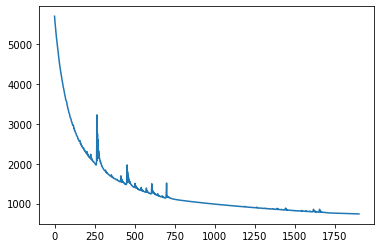

In [28]:
plt.plot(np.arange(len(running_total_loss[100:])), running_total_loss[100:])

Text(0.5, 1.0, 'zoomed in')

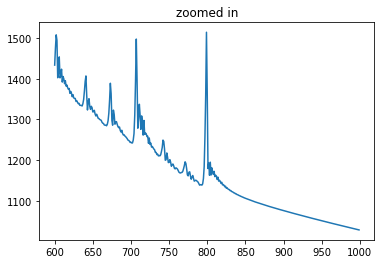

In [25]:
plt.plot(np.arange(600, 600 + len(running_total_loss[600:1000])), running_total_loss[600:1000])
plt.title('zoomed in')

plot above shows epochs 600 - 1000. the lr was updated at epoch 800. We can see that before the lr update, the loss was bouncing around, but after the lr was updated from 0.005 to 0.025, the decrease in the loss became much smoother

### check

In [31]:
G.shape # shape of the gram matrix. should be (channels x channels)

torch.Size([512, 512])

it's 512x512 because layer 28 has 512 channels

In [32]:
A.shape

torch.Size([512, 512])

In [33]:
G

tensor([[ 7306.5186, -5996.5781,   873.8995,  ...,  2587.3022,  6810.8730,
           926.2065],
        [-5996.5781, 10281.9375, -1387.1163,  ..., -1215.2292, -8009.5737,
         -1209.7683],
        [  873.8995, -1387.1163,  3099.5999,  ...,   184.0626,  3092.5254,
           324.3484],
        ...,
        [ 2587.3022, -1215.2292,   184.0626,  ...,  3733.0955,  2751.0405,
           612.7415],
        [ 6810.8730, -8009.5737,  3092.5254,  ...,  2751.0405, 14962.1865,
          1925.5958],
        [  926.2065, -1209.7683,   324.3484,  ...,   612.7415,  1925.5958,
          2532.4216]], device='cuda:0', grad_fn=<MmBackward0>)